In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import Image
from tqdm import tqdm

from torchview import draw_graph
import numpy as np

import matplotlib.pyplot as plt

import sys

sys.path.append("../scripts")
from utils import NpyDataset


In [2]:
bs = 128
epochs = 10

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

print("cuda available:", torch.cuda.is_available())

cuda available: True


In [3]:
base_dir = os.getcwd()
data_folder = "nfft2048_hop1024_nframes16"
processed_data_path = os.path.join(base_dir, 'data', 'training_processed', data_folder)

#sorted(os.listdir(processed_data_path))
# Load Data
dataset = NpyDataset(processed_data_path)

dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

In [4]:
# Fixed input for debugging
fixed_x, label = next(iter(dataloader))
fixed_x.size()

torch.Size([128, 1, 1024, 16])

In [5]:
def conv_t2d_shape(H, stride, kernel_size, padding=0, output_padding=0):
    dilation = 1
    H_out = (H-1)*stride - 2*padding + dilation * (kernel_size - 1) + output_padding + 1
    return H_out

def conv_2d_shape(H, stride, kernel_size, padding=0):
    H_out = (H - kernel_size + 2 * padding) // stride + 1
    return H_out                                       

In [61]:
input_size = 1024
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)


512
256
128
64
32


In [11]:
input_size = 16
input_size = conv_2d_shape(H=input_size, stride=1, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)
input_size = conv_2d_shape(H=input_size, stride=2, kernel_size=3, padding=1)
print(input_size)

16
8
4
2
1


In [27]:
input_size = 32
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)



64
128
256
512
1024


In [18]:
input_size = 1
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=2, kernel_size=3, padding=1, output_padding=1)
print(input_size)
input_size = conv_t2d_shape(H=input_size, stride=1, kernel_size=3, padding=1, output_padding=0)
print(input_size)


2
4
8
16
16


In [14]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=512):
        return input.view(input.size(0), size, 32, 1)

In [69]:
class CVAE(nn.Module):
    def __init__(self, h_dim=16384, z_dim=2):
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
            # input shape: (bs, 1, 1024, 16)
            nn.Conv2d(1, 32, kernel_size=3, stride=(2,1), padding=1),
            nn.ReLU(),
            # input shape: (bs, 32, 512, 16)
            nn.Conv2d(32, 64, kernel_size=3, stride=(2,2), padding=1),
            nn.ReLU(),
            # input shape: (bs, 64, 256, 8)
            nn.Conv2d(64, 128, kernel_size=3, stride=(2,2), padding=1),
            nn.ReLU(),
            # input shape: (bs, 128, 128, 4)
            nn.Conv2d(128, 256, kernel_size=3, stride=(2,2), padding=1),
            nn.ReLU(),
            # input shape: (bs, 256, 64, 2)
            nn.Conv2d(256, 512, kernel_size=3, stride=(2,2), padding=1),
            nn.ReLU(),
            # input shape: (bs, 512, 32, 1)
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
           

        self.decoder = nn.Sequential(
            UnFlatten(),
            # input shape: (bs, 512, 32, 1)
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=(2,2), padding=1, output_padding=(1,1)),
            nn.ReLU(),
            # input shape: (bs, 256, 64, 2)
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=(2,2), padding=1, output_padding=(1,1)),
            nn.ReLU(),
            # input shape: (bs, 128, 128, 4)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=(2,2), padding=1, output_padding=(1,1)),
            nn.ReLU(),
            # input shape: (bs, 64, 256, 8)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=(2,2), padding=1, output_padding=(1,1)),
            nn.ReLU(),
            # input shape: (bs, 32, 512, 16)
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=(2,1), padding=1, output_padding=(1,0)),
            nn.Sigmoid(),
            # output shape: (bs, 1, 1024, 16)
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [70]:
vae = CVAE()
if torch.cuda.is_available():
    vae.cuda()
vae

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Flatten()
  )
  (fc1): Linear(in_features=16384, out_features=2, bias=True)
  (fc2): Linear(in_features=16384, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    

In [ ]:
# visualize model
model_graph = draw_graph(vae, input_size=(128, 1, 1024, 16), expand_nested=True)
model_graph.resize_graph(scale=5.0) # scale as per the view 
model_graph.visual_graph.render(format='svg')
model_graph.visual_graph

In [72]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [73]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [75]:
epochs = 20

In [76]:

for epoch in range(epochs):
    epoch_loss = 0
    for idx, (images, _) in enumerate(tqdm(dataloader, desc="Epoch[{}/{}]".format(epoch+1, epochs), unit="batch")):
        #images = flatten(images)
        recon_images, mu, logvar = vae(to_var(images))
        loss = loss_fn(recon_images, to_var(images), mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()/bs
        epoch_loss += batch_loss
    
        #tqdm.set_postfix(loss=loss.item()/bs, accuracy=0.9)
    print("Average Loss: {}".format(epoch_loss/24))
        #if idx%100 == 0:
        #    print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
    
            #recon_x, _, _ = vae(fixed_x)
            #save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'data/reconstructed_MNIST/recon_image_{epoch}_{idx}.png')


Epoch[1/20]: 100%|██████████| 24/24 [00:04<00:00,  5.15batch/s]


Average Loss: 7121.954976399739


Epoch[2/20]: 100%|██████████| 24/24 [00:04<00:00,  5.34batch/s]


Average Loss: 4495.210906982422


Epoch[3/20]: 100%|██████████| 24/24 [00:04<00:00,  5.38batch/s]


Average Loss: 3861.1686096191406


Epoch[4/20]: 100%|██████████| 24/24 [00:04<00:00,  5.37batch/s]


Average Loss: 3568.7517700195312


Epoch[5/20]: 100%|██████████| 24/24 [00:04<00:00,  5.32batch/s]


Average Loss: 3441.604319254557


Epoch[6/20]: 100%|██████████| 24/24 [00:04<00:00,  5.19batch/s]


Average Loss: 3387.818674723307


Epoch[7/20]: 100%|██████████| 24/24 [00:04<00:00,  5.35batch/s]


Average Loss: 3361.375


Epoch[8/20]: 100%|██████████| 24/24 [00:04<00:00,  5.33batch/s]


Average Loss: 3347.4534352620444


Epoch[9/20]: 100%|██████████| 24/24 [00:04<00:00,  5.37batch/s]


Average Loss: 3332.4338887532554


Epoch[10/20]: 100%|██████████| 24/24 [00:04<00:00,  5.29batch/s]


Average Loss: 3325.708241780599


Epoch[11/20]: 100%|██████████| 24/24 [00:04<00:00,  5.38batch/s]


Average Loss: 3321.8589782714844


Epoch[12/20]: 100%|██████████| 24/24 [00:04<00:00,  4.83batch/s]


Average Loss: 3313.4052124023438


Epoch[13/20]: 100%|██████████| 24/24 [00:04<00:00,  5.22batch/s]


Average Loss: 3313.6671142578125


Epoch[14/20]: 100%|██████████| 24/24 [00:04<00:00,  4.91batch/s]


Average Loss: 3310.3214213053384


Epoch[15/20]: 100%|██████████| 24/24 [00:04<00:00,  5.19batch/s]


Average Loss: 3306.3302205403647


Epoch[16/20]: 100%|██████████| 24/24 [00:04<00:00,  5.28batch/s]


Average Loss: 3306.950368245443


Epoch[17/20]: 100%|██████████| 24/24 [00:04<00:00,  5.62batch/s]


Average Loss: 3305.2432963053384


Epoch[18/20]: 100%|██████████| 24/24 [00:04<00:00,  5.57batch/s]


Average Loss: 3299.2188415527344


Epoch[19/20]: 100%|██████████| 24/24 [00:04<00:00,  5.51batch/s]


Average Loss: 3299.1414744059243


Epoch[20/20]: 100%|██████████| 24/24 [00:04<00:00,  5.30batch/s]

Average Loss: 3298.9303385416665


In [97]:
num_samples = 100
sample = Variable(torch.randn(num_samples, 2)).cuda()
recon_x = vae.decode(sample)
#recon_x, _, _ = vae(fixed_x)


recon_x = recon_x.detach().cpu().numpy()

for i in range(num_samples):
    np.save('data/sample_vae/sample{}'.format(i), recon_x[i,0,:,:])




#save_image(recon_x.view(recon_x.size(0), 1, 1024, 16).data.cpu(), 'data/sample_vae/sample_image1.png')
#Image('data/sample_vae/sample_image1.png')



In [78]:
latent_points = []
latent_labels = []


for idx, (images, labels) in enumerate(dataloader):
    #images = flatten(images)
    recon_images, mu, logvar = vae(to_var(images))

    latent_points.append(mu.cpu().detach().numpy())
    latent_labels.append(labels.cpu().detach().numpy())



#latent_points = np.array(latent_points)
#latent_labels = np.array(latent_labels)
latent_points = np.concatenate(latent_points, axis=0)
latent_labels = np.concatenate(latent_labels, axis=0)


In [79]:

np.shape(latent_points)

(3022, 2)

In [80]:
latent_points[0]

array([ 0.37394968, -0.06941716], dtype=float32)

Text(0.5, 1.0, 'Scatter Plot of 2D Points with Labels')

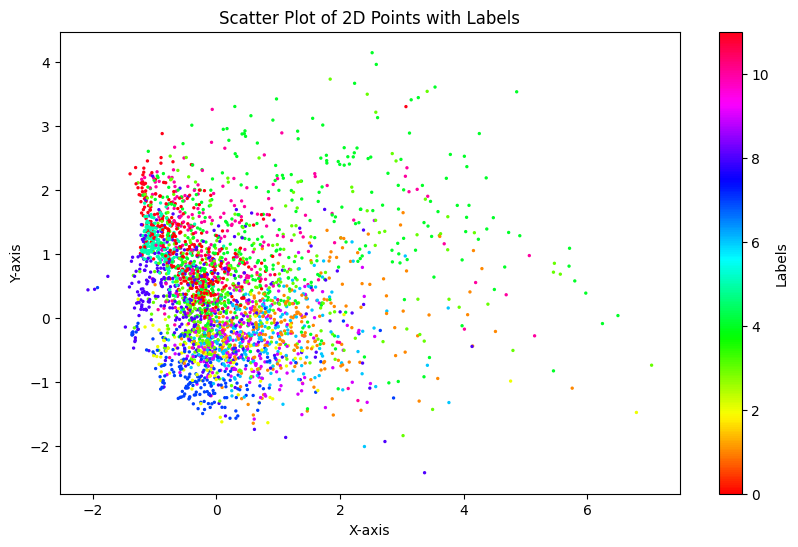

In [83]:
plt.figure(figsize=(10, 6))  # Set the figure size as needed
scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=latent_labels, cmap='hsv', s=2.0)
# Add colorbar
plt.colorbar(scatter, label='Labels')

# Set axis labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of 2D Points with Labels')